### Kalman filter

Heavily inspired by weekly project week 7 and exercise 2 week 7

***Kalman notes***
- Slowing down before occlusion effect.
- Differently tuned filteres for with and without occlusion.
- Stop trusting measurements as we get too close to occlusion.

***TODO***
- Trust model more, to avoid the slowdown problem: but when we reach edge of screen (unseen-window) - increase P to go back to trusting measurements more! (quicker reset)


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

**Kalman filter model**, simple 2d model of world.
- x,y, vx, vy.
- Constant speed, ax, ay = 0

Measured speeds:
- Distorted, no occlusion: \
```vx, vy = [-3.7072721104332675, 1.2003268965304754]```
- Undistorted, no occlusion: \
```vx, vy = [-4.085092303550936, 1.2927642132373258]```
- Unrect, no occlusion: \
```vx, vy = [-4.420334045148261, 1.2415468250308124]```


**4 measurements**

In [2]:
### Initialize Kalman filter ###
# The initial state (4x1).
x = np.array([[0],  # Position along the x-axis
              [0],  # Velocity along the x-axis 
              [0],  # Position along the y-axis
              [0]]) # Velocity along the y-axis 


# The initial uncertainty (4x4) - We start with some very large values.
# Then we will fully trust measurements first iteration.
P = np.array([[1000, 0, 0, 0, 0, 0],
              [0, 1000, 0, 0, 0, 0],
              [0, 0, 1000, 0, 0, 0],
              [0, 0, 0, 1000, 0, 0]])

# The external motion (4x1).
u = np.array([[0], [0], [0], [0]])  # - no external motion 

# The transition matrix (4x4). 
F = np.array([[1, 1, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 1],
              [0, 0, 0, 1]])

# The observation matrix (4x4).
H = np.identity(4)              #H = np.array([[1, 0, 0, 0],
                                #              [0, 1, 0, 0]])

# The measurement uncertainty.
# How little do you want to trust the measurements?
R = 1*np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

# Disturbance matrix
# How little do you want to trust the model?
Q = 1*np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

**2 measurements**

In [3]:
### Initialize Kalman filter ###
# The initial state (4x1).
x = np.array([[0],  # Position along the x-axis
              [0],  # Velocity along the x-axis 
              [0],  # Position along the y-axis
              [0]]) # Velocity along the y-axis 


# The initial uncertainty (4x4) - We start with some very large values.
# Then we will fully trust measurements first iteration.
P = np.array([[1000, 0, 0, 0, 0, 0],
              [0, 1000, 0, 0, 0, 0],
              [0, 0, 1000, 0, 0, 0],
              [0, 0, 0, 1000, 0, 0]])

# The external motion (4x1).
u = np.array([[0], [0], [0], [0]])  # - no external motion 

# The transition matrix (4x4). 
F = np.array([[1, 1, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 1],
              [0, 0, 0, 1]])

# The observation matrix (2x4).
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# The measurement uncertainty.
# How little do you want to trust the measurements?
R = 1*np.array([[1, 0],
                [0, 1]])

# Disturbance matrix
# How little do you want to trust the model?
Q = 1*np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

**Base algorithm**

```Python
running = True
x_range = np.arange(-10, 30, 0.1) # Range of possible xpos
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,6))

# Measurement and state history
zs = []
xs = []

# Flag for new measurements
new_measurement = None

while running:
    if new_measurement:
        # Fresh measurements!
        z = np.array([[...], # xpos
                    [...],   # velx
                    [...],   # ypos
                    [...]])  # vely
        zs.append(z)

        # Update based on new measurements + previous prediction
        x, P = update(x, P, z, H, R)
    else:
        zs.append([None])


    # Predict based on model
    x, P = predict(x, P, F, u, Q)
    xs.append(x)


    # Do some plotting
    #plt.plot(axis, f(x[0], P[0, 0], axis)) # PosX
    ax[0, 0].plot(x_range, f(x[0], P[0, 0], x_range)) # PosX
    ax[0, 1].plot(x_range, f(x[1], P[1, 1], x_range)) # VelX
    ax[1, 0].plot(x_range, f(x[2], P[2, 2], x_range)) # PosY
    ax[1, 1].plot(x_range, f(x[3], P[3, 3], x_range)) # VelY

# plt.title("xpos")
# plt.show()
ax[0, 0].set_title("x pos")
ax[0, 1].set_title("x vel")
ax[1, 0].set_title("y pos")
ax[1, 1].set_title("y vel")
```

### OFFLINE Kalman on Hassans tracker

In [2]:
from tracker import *
import imutils 
import glob
%run tracker.py

In [38]:

# Create tracker object
tracker = EuclideanDistTracker()
#####################################################################################################
#images = glob.glob("video/sample/left/*.png")

# Distorted
#images = glob.glob("video/full/without_occlusions/left/*.png")
#images = glob.glob("video/full/with_occlusions/left/*.png")

# Undistorted
#images = glob.glob("video/full_undistorted/without_occlusions/*.png")
#images = glob.glob("video/full_undistorted/with_occlusions/*.png")

# Unrect - if this works its the best!
images = glob.glob("video/full_unrect/without_occlusions/*.png")
#images = glob.glob("video/full_unrect/with_occlusions/*.png")
#####################################################################################################

no_of_frames = len(images)-1
print("Frames:", no_of_frames)

# Object detection from Stable camera
object_detector = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=40)
xs = []
ys = []

for i in range(no_of_frames):
    frame = cv2.imread(images[i])    
    height, width, _ = frame.shape

    # Extract Region of interest
    rotated = imutils.rotate_bound(frame, 15)
    rotated2=rotated[450:800,350:1250]
    roi = imutils.rotate_bound(rotated2, -15)

    # 1. Object Detection
    mask = object_detector.apply(roi)
    _, mask = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)
    thresh = cv2.dilate(mask, None, iterations=6)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []

    biggest_area=0
    best_cnt = None
    for cnt in contours:
        # Calculate area and remove small elements
        area = cv2.contourArea(cnt)
        if area>biggest_area:
            biggest_area=area
            best_cnt = cnt
    if biggest_area>2000:
        x, y, w, h = cv2.boundingRect(best_cnt)
        detections.append([x, y, w, h])
    # 2. Object Tracking
    boxes_ids = tracker.update(detections)
    if len(detections): # We have seen an object
        for box_id in boxes_ids:
            x, y, w, h, id = box_id
            x=x-25
            y=y-25
            w=w+50
            h=h+50
            cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 3)
            #cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 255, 0), 3)
            #cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
    
            # For KALMAN FILTER
            xs.append(x + w//2)
            ys.append(y + h//2)

    else: # No object detected
        # For KALMAN FILTER
        xs.append(None)
        ys.append(None)


    cv2.imshow("roi", roi)
    #cv2.imshow("Frame", frame)
    #cv2.imshow("Mask", thresh)

    # For nice visualization
    #cv2.waitKey(30)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # q will end the program
        break

cv2.destroyAllWindows()

Frames: 1566


In [7]:

measurements = np.vstack((np.asarray(xs), np.asarray(ys)))
print("measurements", measurements.shape)

measurements (2, 1566)


Kalman filtered states (4, 1566)
Average xvel: -3.5303358298774166 (pixels/frame)
Average yvel: 1.2243988391899239 (pixels/frame)


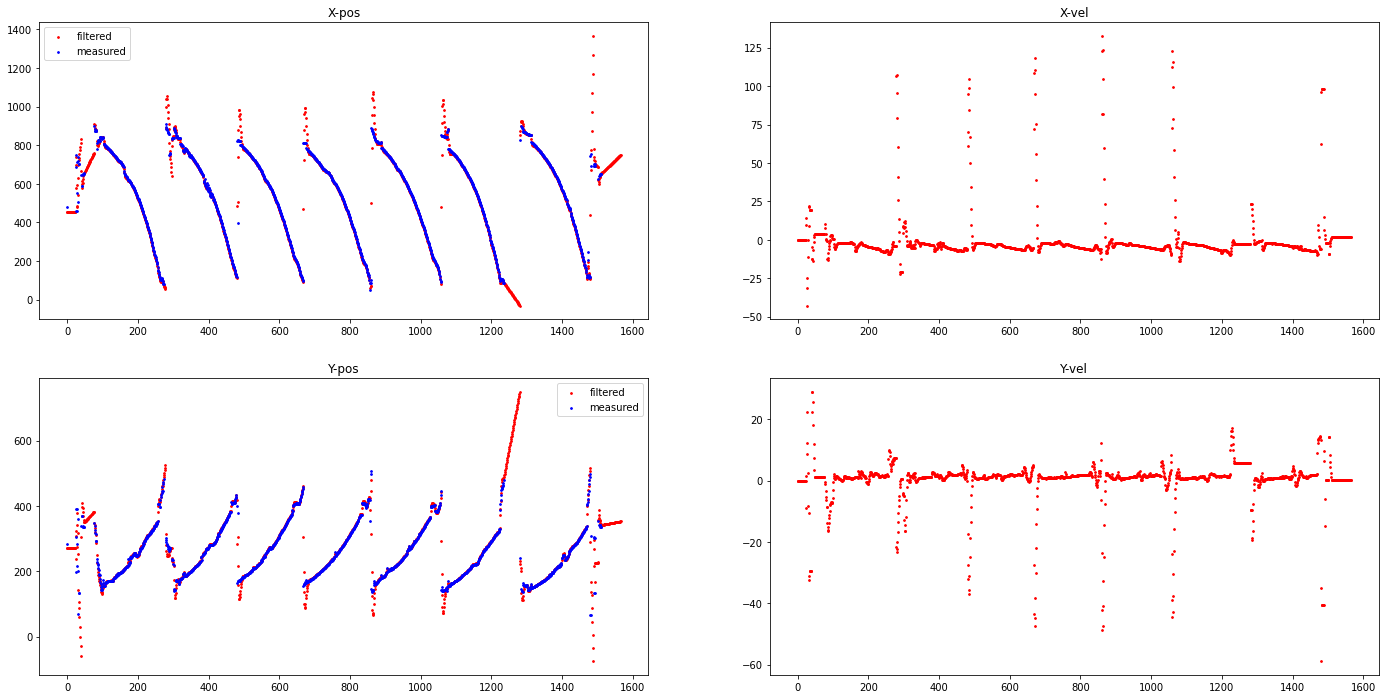

In [8]:
from kalman import *
from scipy import stats
%run kalman.py

filtered = offline_kalman(measurements)
print("Kalman filtered states", filtered.shape)

#print("Average xvel:", np.mean(filtered[1, :]),"(pixels/frame)")
#print("Average yvel:", np.mean(filtered[3, :]),"(pixels/frame)")
print("Average xvel:", stats.trim_mean(filtered[1, :], 0.2),"(pixels/frame)")
print("Average yvel:", stats.trim_mean(filtered[3, :], 0.2),"(pixels/frame)")


time = np.arange(0,len(xs), 1)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
axs[0, 0].scatter(time, filtered[0, :], s=3, c="red", label="filtered") # X-pos
axs[0, 0].scatter(time, measurements[0, :], s=3, c="blue", label="measured") # measured X-pos
axs[0, 0].set_title("X-pos")
axs[0, 0].legend()
axs[0, 1].scatter(time, filtered[1, :], s=3, c="red") # X-vel
axs[0, 1].set_title("X-vel")
axs[1, 0].scatter(time, filtered[2, :], s=3, c="red", label="filtered") # Y-pos
axs[1, 0].scatter(time, measurements[1, :], s=3, c="blue", label="measured") # Y-pos
axs[1, 0].set_title("Y-pos")
axs[1, 0].legend()
axs[1, 1].scatter(time, filtered[3, :], s=3, c="red") # Y-vel
axs[1, 1].set_title("Y-vel");

### Online KALMAN

**A simple** filter with the constant speeds added.

In [9]:
### Initialize Kalman filter ###
# The initial state (4x1).
states = np.array([[0],  # Pos along the x-axis
                   [0]])  # Pos along the y-axis 

# The initial uncertainty (2x2) - We start with some very large values.
# Then we will fully trust measurements first iteration.
P = np.array([[1000, 0],
              [0, 1000]])

# The external motion (2x1).
u = np.array([[-3.7072721104332675], # Measured average xvel
              [1.2003268965304754]]) # Measured average yvel

# The transition matrix (2x2). 
F = np.array([[1, 0],
              [0, 1]])

# The observation matrix (2x4).
H = np.array([[1, 0],
              [0, 1]])

# The measurement uncertainty.
# How little do you want to trust the measurements?
R = 1*np.array([[50, 0],
                [0, 50]])

# Disturbance matrix
# How little do you want to trust the model?
Q = 1*np.array([[1, 0],
                [0, 1]])

In [14]:

# Create tracker object
tracker = EuclideanDistTracker()


################################################################## CHOOSE VIDEO ##################################################################
#images = glob.glob("video/sample/left/*.png")

# Distorted
#images = glob.glob("video/full/without_occlusions/left/*.png")
images = glob.glob("video/full/with_occlusions/left/*.png")

# Undistorted
#images = glob.glob("video/full_undistorted/without_occlusions/left/*.png")
#images = glob.glob("video/full_undistorted/with_occlusions/left/*.png")
###################################################################################################################################################


no_of_frames = len(images)-1
print("Frames:", no_of_frames)

# Object detection from Stable camera
object_detector = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=40)
xs = []
ys = []

filtered = np.zeros((2, no_of_frames))

for i in range(no_of_frames):
    frame = cv2.imread(images[i])    
    height, width, _ = frame.shape

    # Extract Region of interest
    rotated = imutils.rotate_bound(frame, 15)
    rotated2=rotated[450:800,350:1250]
    roi = imutils.rotate_bound(rotated2, -15)

    # 1. Object Detection
    mask = object_detector.apply(roi)
    _, mask = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)
    thresh = cv2.dilate(mask, None, iterations=6)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []

    biggest_area=0
    best_cnt = None
    for cnt in contours:
        # Calculate area and remove small elements
        area = cv2.contourArea(cnt)
        if area>biggest_area:
            biggest_area=area
            best_cnt = cnt
    if biggest_area>2000:
        x, y, w, h = cv2.boundingRect(best_cnt)
        detections.append([x, y, w, h])
    ##################################################################################
    # 2. Object Tracking, Kalman filter
    boxes_ids = tracker.update(detections)
    if len(detections): # We have seen an object
        for box_id in boxes_ids:
            x, y, w, h, id = box_id
            x=x-25
            y=y-25
            w=w+50
            h=h+50
            cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 3)
            #cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 255, 0), 3)
            #cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
    
            
            #####################################################
            c_x = x + w//2
            c_y = y + h//2
            xs.append(c_x)
            ys.append(c_y)
            # For KALMAN FILTER
            z = np.array([[c_x],  # xpos
                          [c_y]]) # ypos
            # Update based on new measurements + previous prediction
            states, P = update(states, P, z, H, R)
            #####################################################
            # Measured
            cv2.circle(roi, (np.int32(states[0, 0]), np.int32(states[1, 0])), 8, color=(0, 255, 0), thickness=-1)


    else: # No object detected
        xs.append(None)
        ys.append(None)
    
    states, P = predict(states, P, F, u, Q)
    # Predicted
    cv2.circle(roi, (np.int32(states[0, 0]), np.int32(states[1, 0])), 8, color=(0, 0, 255), thickness=-1)
    filtered[:, i] = states.reshape((2,))

    cv2.imshow("roi", roi)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # q will end the program
        break

measurements = np.vstack((np.asarray(xs), np.asarray(ys)))
print("measurements", measurements.shape)
print("filtered", filtered.shape)

cv2.destroyAllWindows()

Frames: 1452
measurements (2, 1011)
filtered (2, 1452)


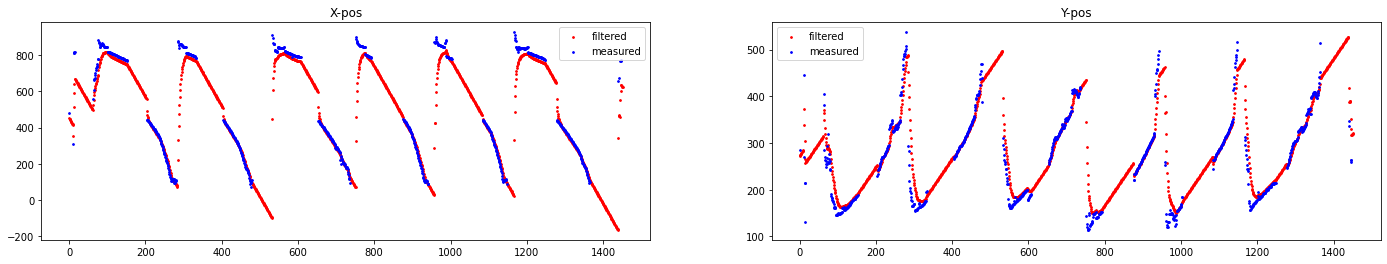

In [11]:
time = np.arange(0,len(xs), 1)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 4))
axs[0].scatter(time, filtered[0, :], s=3, c="red", label="filtered") # X-pos
axs[0].scatter(time, measurements[0, :], s=3, c="blue", label="measured") # measured X-pos
axs[0].set_title("X-pos")
axs[0].legend()
axs[1].scatter(time, filtered[1, :], s=3, c="red", label="filtered") # Y-pos
axs[1].scatter(time, measurements[1, :], s=3, c="blue", label="measured") # Y-pos
axs[1].set_title("Y-pos")
axs[1].legend();

### Offline Kalman 2.0

In [39]:
# Create tracker object
tracker = EuclideanDistTracker()
#####################################################################################################
#images = glob.glob("video/sample/left/*.png")

# Distorted
#images = glob.glob("video/full/without_occlusions/left/*.png")
#images = glob.glob("video/full/with_occlusions/left/*.png")

# Undistorted
#images = glob.glob("video/full_undistorted/without_occlusions/*.png")
#images = glob.glob("video/full_undistorted/with_occlusions/*.png")

# Unrect - if this works its the best!
images = glob.glob("video/full_unrect/without_occlusions/*.png")
#images = glob.glob("video/full_unrect/with_occlusions/*.png")
#####################################################################################################

# Object detection
object_detector = cv2.createBackgroundSubtractorKNN(history=100, dist2Threshold=1200)
no_of_frames = len(images)-1
print("Frames:", no_of_frames)

# Measurement history
xs = []
ys = []

for i in range(no_of_frames):
    frame = cv2.imread(images[i]) 
    #height, width, _ = frame.shape

    # 1. Object Detection
    mask = object_detector.apply(frame)
    _, mask = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)
    thresh = cv2.dilate(mask, None, iterations=6)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []

    biggest_area=0
    best_cnt = None
    for cnt in contours:
        # Calculate area and remove small elements
        area = cv2.contourArea(cnt)
        if area>biggest_area:
            biggest_area=area
            best_cnt = cnt
    if (biggest_area>4500 and biggest_area<76000):
        x, y, w, h = cv2.boundingRect(best_cnt)
        detections.append([x, y, w, h])
        # 2. Object Tracking
        box_id = tracker.update(detections)[0]
        
        if (x>0 and x<1200)and(y>200 and y<730):
            x, y, w, h, id = box_id
            rx=x-25
            ry=y-25
            rw=w+50
            rh=h+50
            centerx=(rx+rx+rw)//2
            centery=(ry+ry+rh)//2
            cv2.rectangle(frame, (rx, ry), (rx + rw, ry + rh), (0, 255, 0), 3)
            cv2.circle(frame,(centerx,centery),5,(0,0,255), -1)
            """ 
            #cv2.putText(frame, "Area: {}".format(area), (rx, ry+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            #cv2.putText(frame, "Centroid: ({}, {})".format(centerx, centery), (rx, ry+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            #cv2.putText(frame, "Height: {}".format(h), (rx, ry+60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            #cv2.putText(frame, "Width: {}".format(w), (rx, ry+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            #cv2.putText(frame, "Object: {}".format('box'), (rx, ry-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)   # From object detection.
            """
            # For KALMAN
            xs.append(centerx)
            ys.append(centery)
        
        else:
            # For KALMAN
            xs.append(None)
            ys.append(None)

    else:
        # For KALMAN
        xs.append(None)
        ys.append(None)
            
                

    cv2.imshow("Frame", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):  # q will end the program
        break

cv2.destroyAllWindows()

Frames: 1566


In [40]:

measurements = np.vstack((np.asarray(xs), np.asarray(ys)))
print("measurements", measurements.shape)

measurements (2, 1566)


Kalman filtered states (4, 1566)
Average xvel: -4.420334045148261 (pixels/frame)
Average yvel: 1.2415468250308124 (pixels/frame)


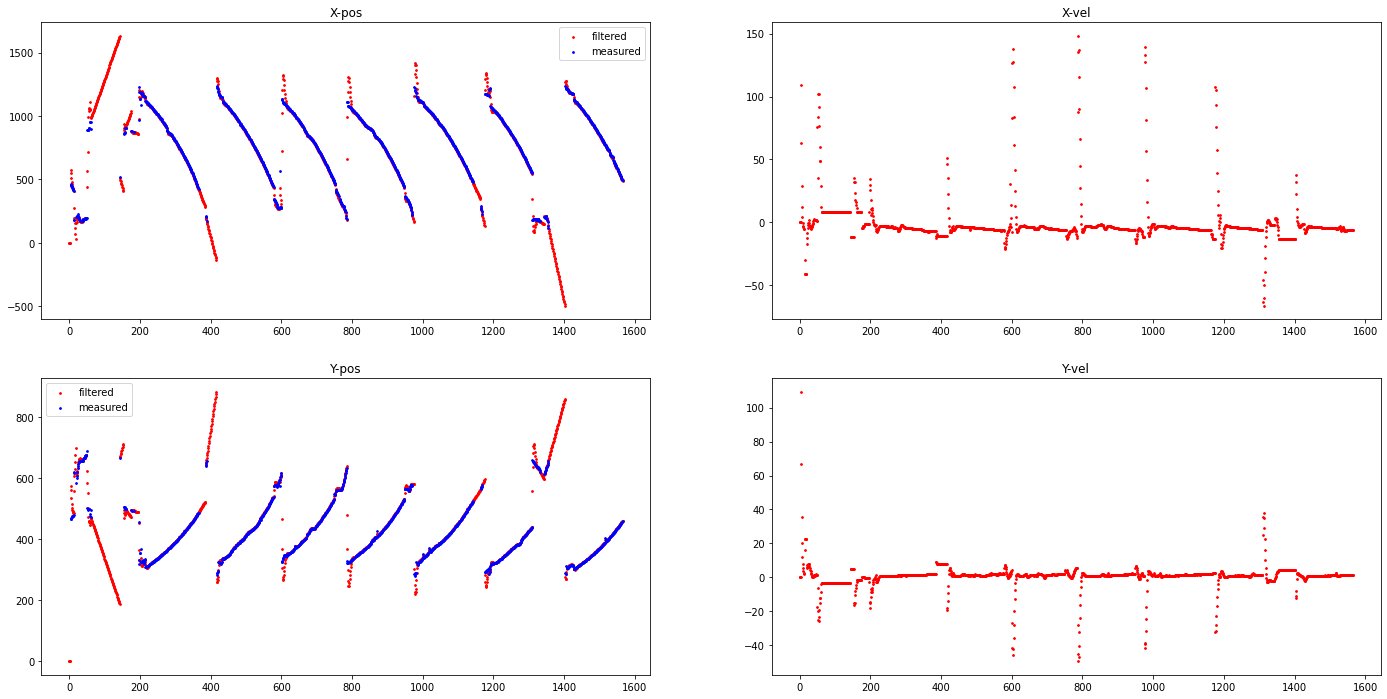

In [41]:
from kalman import *
from scipy import stats
%run kalman.py

filtered = offline_kalman(measurements)
print("Kalman filtered states", filtered.shape)
print("Average xvel:", stats.trim_mean(filtered[1, :], 0.2),"(pixels/frame)")
print("Average yvel:", stats.trim_mean(filtered[3, :], 0.2),"(pixels/frame)")

time = np.arange(0,len(xs), 1)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
axs[0, 0].scatter(time, filtered[0, :], s=3, c="red", label="filtered") # X-pos
axs[0, 0].scatter(time, measurements[0, :], s=3, c="blue", label="measured") # measured X-pos
axs[0, 0].set_title("X-pos")
axs[0, 0].legend()
axs[0, 1].scatter(time, filtered[1, :], s=3, c="red") # X-vel
axs[0, 1].set_title("X-vel")
axs[1, 0].scatter(time, filtered[2, :], s=3, c="red", label="filtered") # Y-pos
axs[1, 0].scatter(time, measurements[1, :], s=3, c="blue", label="measured") # Y-pos
axs[1, 0].set_title("Y-pos")
axs[1, 0].legend()
axs[1, 1].scatter(time, filtered[3, :], s=3, c="red") # Y-vel
axs[1, 1].set_title("Y-vel");

## Online Kalman 2.0

In [66]:
### Initialize Kalman filter ###
# The initial state (4x1).
states = np.array([[0],  # Pos along the x-axis
                   [0]])  # Pos along the y-axis 

# The initial uncertainty (2x2) - We start with some very large values.
# Then we will fully trust measurements first iteration.
P = np.array([[1000, 0],
              [0, 1000]])

# The external motion (2x1).
u = np.array([[-4.420334045148261], # Measured average xvel
              [1.2415468250308124]]) # Measured average yvel

# Distorted [-3.7072721104332675, 1.2003268965304754]
# Undistorted [-4.085092303550936, 1.2927642132373258]
# Unrect [-4.420334045148261, 1.2415468250308124]


# The transition matrix (2x2). 
F = np.array([[1, 0],
              [0, 1]])

# The observation matrix (2x4).
H = np.array([[1, 0],
              [0, 1]])

# The measurement uncertainty.
# How little do you want to trust the measurements?
R = 1*np.array([[50, 0],
                [0, 50]])
bad_R = 100*R.copy()

# Disturbance matrix
# How little do you want to trust the model?
Q = 1*np.array([[1, 0],
                [0, 1]])

In [73]:
# Create tracker object
tracker = EuclideanDistTracker()
#####################################################################################################
#images = glob.glob("video/sample/left/*.png")

# Distorted
#images = glob.glob("video/full/without_occlusions/left/*.png")
#images = glob.glob("video/full/with_occlusions/left/*.png")

# Undistorted
#images = glob.glob("video/full_undistorted/without_occlusions/*.png")
#images = glob.glob("video/full_undistorted/with_occlusions/*.png")

# Unrect - if this works its the best!
images = glob.glob("video/full_unrect/without_occlusions/*.png")
#images = glob.glob("video/full_unrect/with_occlusions/*.png")

occlusion=True
#####################################################################################################

# Object detection
object_detector = cv2.createBackgroundSubtractorKNN(history=100, dist2Threshold=1200)
no_of_frames = len(images)-1
print("Frames:", no_of_frames)

# Measurement/filter history
xs = []
ys = []
filtered = np.zeros((2, no_of_frames))

# The movie/image loop
for i in range(no_of_frames):
    frame = cv2.imread(images[i]) 

    # 1
    # Object detection
    mask = object_detector.apply(frame)
    _, mask = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)
    thresh = cv2.dilate(mask, None, iterations=6)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 2
    # Only keep biggest objects
    biggest_area=0
    best_cnt = None
    for cnt in contours:
        # Calculate area and remove small elements
        area = cv2.contourArea(cnt)
        if area>biggest_area:
            biggest_area=area
            best_cnt = cnt
    # 3 
    # Constrain/limit search using heuristics
    if (biggest_area>4500 and biggest_area<76000): # reasonable size
        x, y, w, h = cv2.boundingRect(best_cnt)
        box_id = tracker.update([[x, y, w, h]])[0] # Track object
        
        if (x>200 and x<1200)and(y>200 and y<550): # On the conveyor
            x, y, w, h, id = box_id
            # Increase box bound beyond the default.
            rx=x-25
            ry=y-25
            rw=w+50
            rh=h+50
            centerx=(rx+rx+rw)//2
            centery=(ry+ry+rh)//2
            cv2.rectangle(frame, (rx, ry), (rx + rw, ry + rh), (0, 255, 0), 3)
            cv2.circle(frame,(centerx,centery),5,(0,255,0), -1)
            
            # Append measurements
            xs.append(centerx)
            ys.append(centery)

            # Cropping for classification
            crop_img = frame[y:y+h, x:x+w].copy()
            ncrop_img=cv2.resize(crop_img, (128, 128), interpolation = cv2.INTER_AREA)
            cv2.imshow("Cropped", ncrop_img)

            # Kalman update from measurements
            z = np.array([[centerx],  # xpos
                          [centery]]) # ypos

            # Occlusion limits
            if occlusion and (centerx>550 and centerx<1100): # Close to occlusion
                cv2.putText(frame, "Mood: {}".format('BAD'), (rx, ry-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)  
                states, P = update(states, P, z, H, bad_R)
            else: # Far from occlusion
                cv2.putText(frame, "Mood: {}".format('GOOD'), (rx, ry-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                states, P = update(states, P, z, H, R)
        
        else: # Off the conveyor
            xs.append(None)
            ys.append(None)
            # Reset model uncertainty
            P = np.array([[1000, 0],
                          [0, 1000]])

    else: # Unreasonable object
        xs.append(None)
        ys.append(None)

    # Kalman prediction 
    states, P = predict(states, P, F, u, Q)
    cv2.circle(frame, (np.int32(states[0, 0]), np.int32(states[1, 0])), 8, color=(255, 0, 0), thickness=-1)
    filtered[:, i] = states.reshape((2,))

    # Show the movie
    cv2.imshow("Frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # q will end the program
        break

cv2.destroyAllWindows()

Frames: 1566


In [74]:
measurements = np.vstack((np.asarray(xs), np.asarray(ys)))
print("measurements", measurements.shape)

measurements (2, 1566)


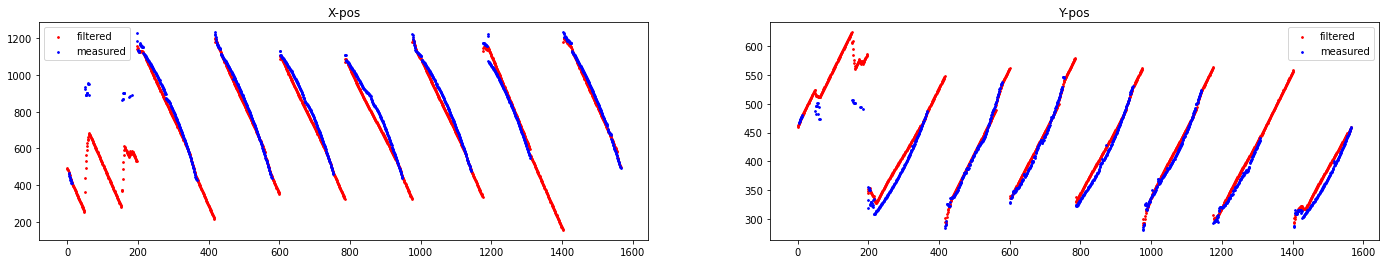

In [75]:
time = np.arange(0,len(xs), 1)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 4))
axs[0].scatter(time, filtered[0, :], s=3, c="red", label="filtered") # X-pos
axs[0].scatter(time, measurements[0, :], s=3, c="blue", label="measured") # measured X-pos
axs[0].set_title("X-pos")
axs[0].legend()
axs[1].scatter(time, filtered[1, :], s=3, c="red", label="filtered") # Y-pos
axs[1].scatter(time, measurements[1, :], s=3, c="blue", label="measured") # Y-pos
axs[1].set_title("Y-pos")
axs[1].legend();

## Extract code into a class

In [ ]:

#####################################################################################################
#images = glob.glob("video/sample/left/*.png")

# Distorted
#images = glob.glob("video/full/without_occlusions/left/*.png")
#images = glob.glob("video/full/with_occlusions/left/*.png")

# Undistorted
#images = glob.glob("video/full_undistorted/without_occlusions/*.png")
#images = glob.glob("video/full_undistorted/with_occlusions/*.png")

# Unrect - if this works its the best!
images = glob.glob("video/full_unrect/without_occlusions/*.png")
#images = glob.glob("video/full_unrect/with_occlusions/*.png")

occlusion=True
#####################################################################################################
# Object detection
object_detector = cv2.createBackgroundSubtractorKNN(history=100, dist2Threshold=1200)
no_of_frames = len(images)-1
print("Frames:", no_of_frames)

# Init tracker
tracker = Kalman_tracker(occlusion=False)
# The movie/image loop
for i in range(no_of_frames):
    frame = cv2.imread(images[i]) 

    track_frame, filtered, measured = tracker.next_frame(frame)

**Usefull** little code

In [56]:
#import os
#for i in range(0,1452+1):
#    old_name = r"C:\Users\henri\OneDrive\Desktop\DTU courses\31392 Perception\Final project\tracking\video\full_unrect\with_occlusions\left-"+str(i)+".png"
#    new_name = r"C:\Users\henri\OneDrive\Desktop\DTU courses\31392 Perception\Final project\tracking\video\full_unrect\with_occlusions\left_"+str(i).rjust(4, "0")+".png"
#
#    if os.path.isfile(new_name):
#        print("The file already exists")
#    else:
#        # Rename the file
#        os.rename(old_name, new_name)